# Loader Experiments: GicaHack Meter Data

This notebook showcases loading, cleaning, and baseline forecasting using the `GicaHackDataLoader` from the `energy_pred` package.

In [1]:
# 1. Environment & Imports
import sys, os, warnings, random
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Ensure project root is on path
sys.path.append('/home/sultanan/energy')
from energy_pred import (
    GicaHackDataLoader,
    NaiveForecaster,
    SeasonalNaiveForecaster,
    MovingAverageForecaster,
    ExpSmoothingForecaster,
    mae, mape, rmse
)
print('Imports OK')

Imports OK


In [2]:
# 2. Load CSV Exports with GicaHackDataLoader
DATA_DIR = '/home/sultanan/datasets/energy/GicaHack'
loader = GicaHackDataLoader(DATA_DIR, verbose=True)
loader.load()
raw_df = loader.get_raw()
print('Raw shape:', raw_df.shape)
print(raw_df.head())
print('Meters:', loader.list_meters()[:10])
print(loader.stats().head())

Skipping empty file: 03.06.2025 06_00_All measuring points_ExportFile.csv
Skipping empty file: 03.06.2025 18_01_All measuring points_ExportFile.csv
Skipping empty file: 04.06.2025 06_00_All measuring points_ExportFile.csv
Concatenated shape: (2254330, 5)
Raw shape: (2254330, 8)
      meter           timestamp  energy_import  energy_export  transform_coef  \
0  13836498 2025-06-01 12:15:00      6517117.0          469.0             1.0   
1  13836498 2025-06-01 12:30:00      6517160.0          469.0             1.0   
2  13836498 2025-06-01 12:45:00      6517205.0          469.0             1.0   
3  13836498 2025-06-01 13:00:00      6517249.0          469.0             1.0   
4  13836498 2025-06-01 13:15:00      6517296.0          469.0             1.0   

   import_diff  export_diff  period_min  
0          0.0          0.0         0.0  
1         43.0          0.0        15.0  
2         45.0          0.0        15.0  
3         44.0          0.0        15.0  
4         47.0          

In [3]:
raw_df#['meter']#.unique()#.size

,meter,timestamp,energy_import,energy_export,transform_coef,import_diff,export_diff,period_min
0,13836498,2025-06-01 12:15:00,6517117.0,469.0,1.0,0.0,0.0,0.0
1,13836498,2025-06-01 12:30:00,6517160.0,469.0,1.0,43.0,0.0,15.0
2,13836498,2025-06-01 12:45:00,6517205.0,469.0,1.0,45.0,0.0,15.0
3,13836498,2025-06-01 13:00:00,6517249.0,469.0,1.0,44.0,0.0,15.0
4,13836498,2025-06-01 13:15:00,6517296.0,469.0,1.0,47.0,0.0,15.0
...,...,...,...,...,...,...,...,...
2254325,15005960,2025-06-08 08:00:00,79438.0,340.0,1.0,134.0,0.0,60.0
2254326,15005960,2025-06-08 09:00:00,79551.0,340.0,1.0,113.0,0.0,60.0
2254327,15005960,2025-06-08 10:00:00,79962.0,340.0,1.0,411.0,0.0,60.0
2254328,15005960,2025-06-08 11:00:00,80333.0,340.0,1.0,371.0,0.0,60.0


In [4]:
raw_df['meter'].value_counts()

meter
14461598    1385
14461563    1362
14462354    1340
14462950    1339
14461904    1321
            ... 
14461261       1
14461426       1
14460416       1
14381623       1
14381688       1
Name: count, Length: 11871, dtype: int64

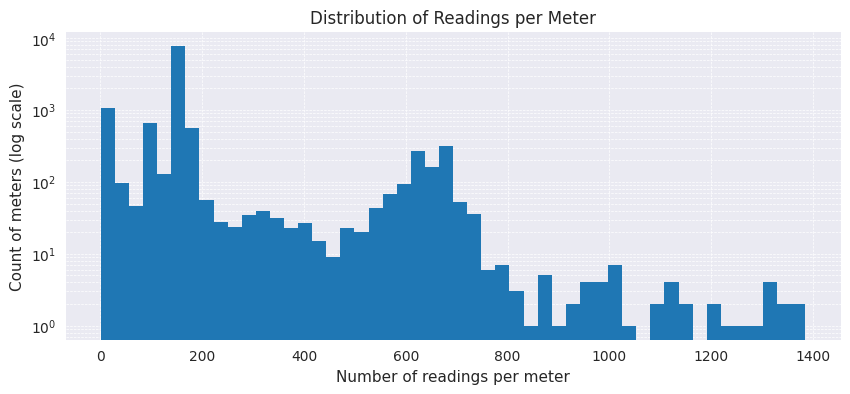

In [5]:
# distribution of readings per meter
plt.figure(figsize=(10,4))
plt.hist(raw_df['meter'].value_counts(), bins=50, color='tab:blue')
plt.yscale('log')
plt.xlabel('Number of readings per meter')
plt.ylabel('Count of meters (log scale)')
plt.title('Distribution of Readings per Meter')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Sample meter: [np.int64(15002513), np.int64(14462758), np.int64(14460600), np.int64(14947590), np.int64(14946456), np.int64(14945888), np.int64(14943525), np.int64(14462537), np.int64(15004036), np.int64(14999260)]


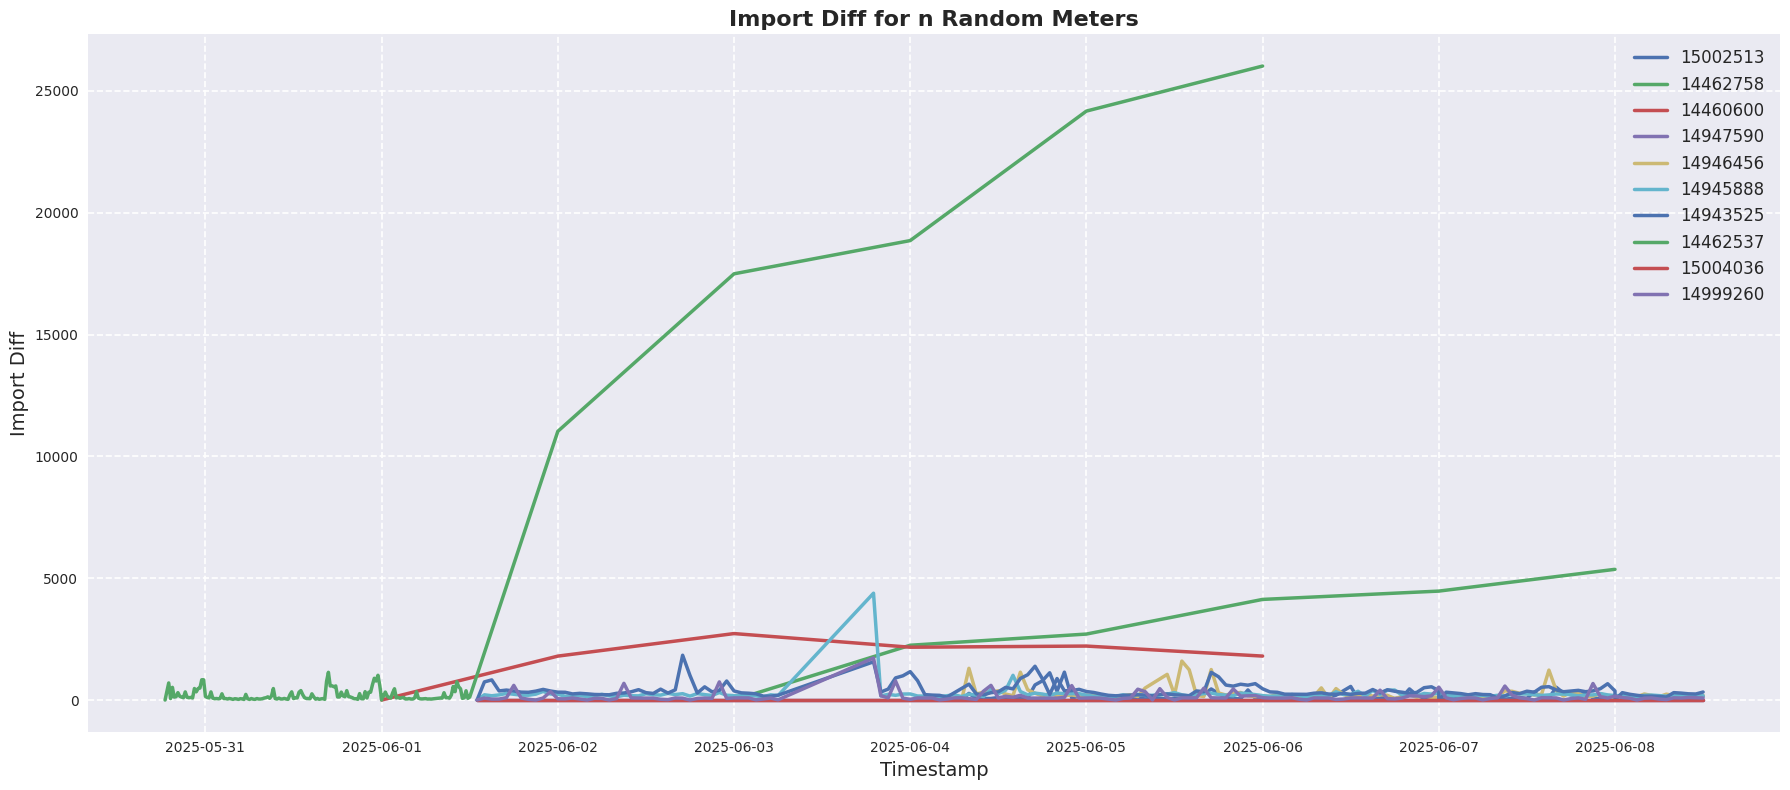

In [6]:
# plot random n meter import_diff
n = 10
m1, m2 = 0, 1
sample_meters = random.sample(list(raw_df['meter'].unique()), n)
# sample_meters = [14945833]  # specific meter with good data
print('Sample meter:', sample_meters)
plt.figure(figsize=(18,8))
for meter in sample_meters:
    df_meter = raw_df[raw_df['meter'] == meter].sort_values('timestamp')
    # print(df_meter.head())
    # plt.plot(df_meter['timestamp'], df_meter['import_diff'], label=meter, linewidth=2.5)
    # plot between from m1 period to m2 period
    start_idx = int(len(df_meter) * m1)
    end_idx = int(len(df_meter) * m2)
    # print(start_idx, end_idx)
    plt.plot(df_meter['timestamp'].iloc[start_idx:end_idx], df_meter['import_diff'].iloc[start_idx:end_idx], label=meter, linewidth=2.5)
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Import Diff', fontsize=14)
plt.title('Import Diff for n Random Meters', fontsize=16, weight='bold')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Meter 14945833 Energy Import'}, xlabel='timestamp'>

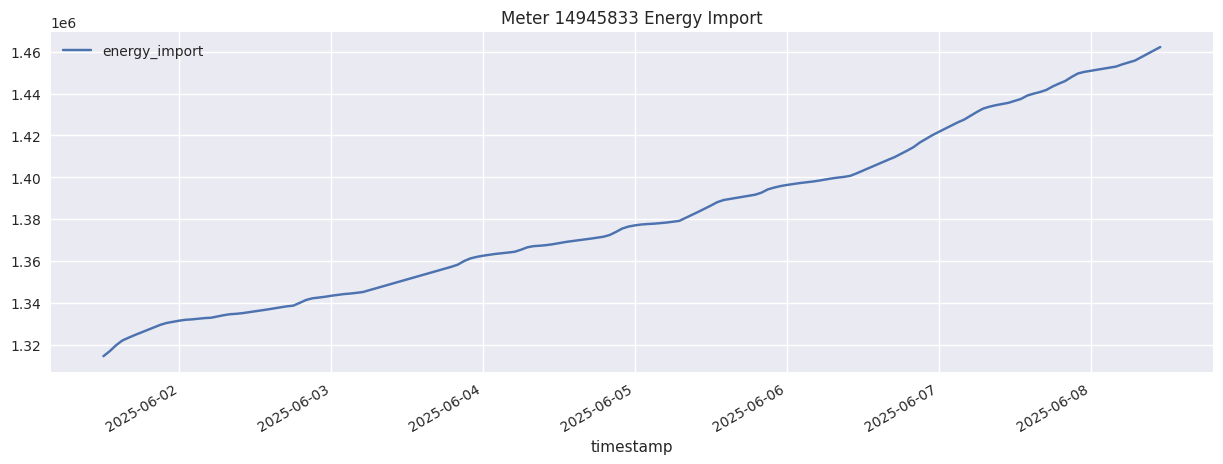

In [7]:
raw_df[raw_df['meter'] == 14945833].plot(x='timestamp', y=['energy_import'], figsize=(15,5), title='Meter 14945833 Energy Import')

<Axes: xlabel='timestamp'>

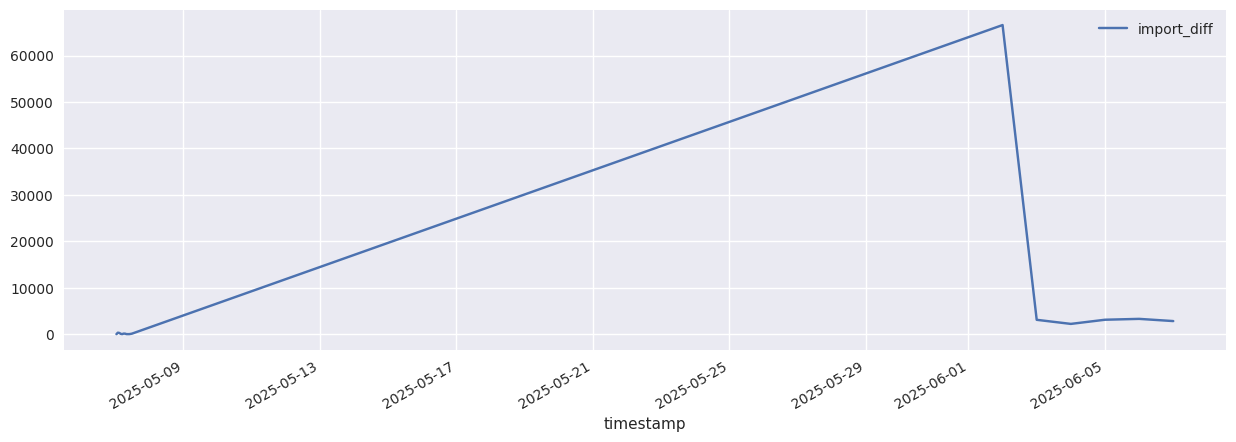

In [8]:
raw_df[raw_df['meter'] == 15001731].plot(x='timestamp', y=['import_diff'], figsize=(15,5))

In [9]:
raw_df[raw_df['meter'] == 13836498]


,meter,timestamp,energy_import,energy_export,transform_coef,import_diff,export_diff,period_min
0,13836498,2025-06-01 12:15:00,6517117.0,469.0,1.0,0.0,0.0,0.0
1,13836498,2025-06-01 12:30:00,6517160.0,469.0,1.0,43.0,0.0,15.0
2,13836498,2025-06-01 12:45:00,6517205.0,469.0,1.0,45.0,0.0,15.0
3,13836498,2025-06-01 13:00:00,6517249.0,469.0,1.0,44.0,0.0,15.0
4,13836498,2025-06-01 13:15:00,6517296.0,469.0,1.0,47.0,0.0,15.0
...,...,...,...,...,...,...,...,...
667,13836498,2025-06-08 11:00:00,6568316.0,469.0,1.0,53.0,0.0,15.0
668,13836498,2025-06-08 11:15:00,6568371.0,469.0,1.0,55.0,0.0,15.0
669,13836498,2025-06-08 11:30:00,6568426.0,469.0,1.0,55.0,0.0,15.0
670,13836498,2025-06-08 11:45:00,6568481.0,469.0,1.0,55.0,0.0,15.0


In [10]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
total_hourly = raw_df['import_diff'].groupby(raw_df['timestamp'].dt.hour).sum()

# Fit ARIMA model for forecasting
model = ARIMA(total_hourly, order=(1, 0, 0))  # Simple AR(1) model
model_fit = model.fit()
print(model_fit.summary())

def predict_consumption(update_df):
    
    # Calculate latest delta (assuming 'energy_import' matches your update format)
    latest_delta = update_df['energy_import'].diff().iloc[-1] if len(update_df) > 1 else 0
    if latest_delta == 0 and not update_df.empty:
        latest_delta = update_df['energy_import'].iloc[-1] - raw_df['import_diff'].iloc[-1]  # Approx from last known

    # Predict next 6 hours (challenge requires actionable forecasts)
    forecast = model_fit.forecast(steps=6)
    adjusted_forecast = forecast + (latest_delta * 4)  # Scale 15-min delta to hourly

    # Add basic peak detection (simplified for MVP)
    peak_threshold = total_hourly.mean() + total_hourly.std() * 2
    peaks = [f if f > peak_threshold else 0 for f in adjusted_forecast]
    
    return adjusted_forecast.tolist(), peaks

                               SARIMAX Results                                
Dep. Variable:            import_diff   No. Observations:                   24
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -496.251
Date:                Sat, 13 Sep 2025   AIC                            998.501
Time:                        13:35:15   BIC                           1002.035
Sample:                             0   HQIC                           999.439
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.034e+07   6.53e+05     31.168      0.000    1.91e+07    2.16e+07
ar.L1          0.1439      0.028      5.051      0.000       0.088       0.200
sigma2      4.621e+13      0.618   7.47e+13      0.0

In [11]:
# 3. Select Primary Meter & Extract Series
meters = loader.list_meters()
if not meters:
    raise RuntimeError('No meters found')
primary_meter = meters[0]
print('Primary meter:', primary_meter)
series = loader.meter_series(primary_meter, column='import_diff', aggregate_duplicates='mean', reindex=True)
print(series.head())
print('Length:', len(series), 'NaNs:', series.isna().sum())

Primary meter: 13836498
timestamp
2025-06-01 12:15:00     0.0
2025-06-01 12:30:00    43.0
2025-06-01 12:45:00    45.0
2025-06-01 13:00:00    44.0
2025-06-01 13:15:00    47.0
Freq: 15min, Name: import_diff, dtype: float64
Length: 672 NaNs: 0


Gap report (top 5):
Empty DataFrame
Columns: [start, end, length]
Index: []


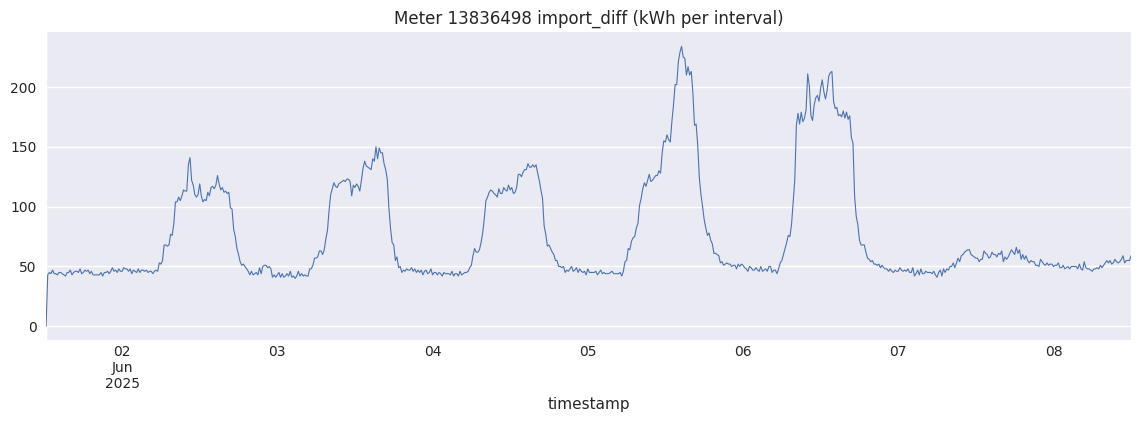

In [12]:
# 4. Gap Report & Quick Visualization
report = loader.gap_report(primary_meter, column='import_diff')
print('Gap report (top 5):')
print(report.head())

series_clean = series.copy()
# Simple interpolation for short gaps
series_clean = series_clean.interpolate(limit=2)

fig, ax = plt.subplots(figsize=(14,4))
series_clean.plot(ax=ax, lw=0.8)
ax.set_title(f'Meter {primary_meter} import_diff (kWh per interval)')
plt.show()


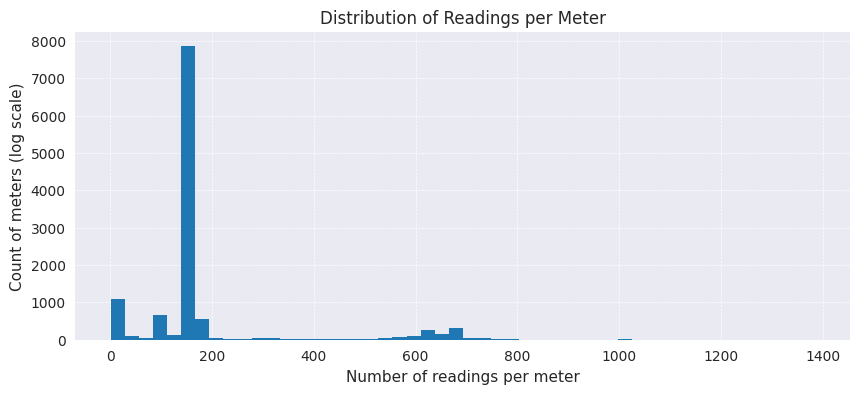

In [13]:
# plot histogram of number of readings per meter
# --- IGNORE ---
plt.figure(figsize=(10,4))
plt.hist(raw_df['meter'].value_counts(), bins=50, color='tab:blue')
# plt.yscale('log')
plt.xlabel('Number of readings per meter')
plt.ylabel('Count of meters (log scale)')
plt.title('Distribution of Readings per Meter')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [14]:
# number of all meters
len(raw_df['meter'].unique())

11871

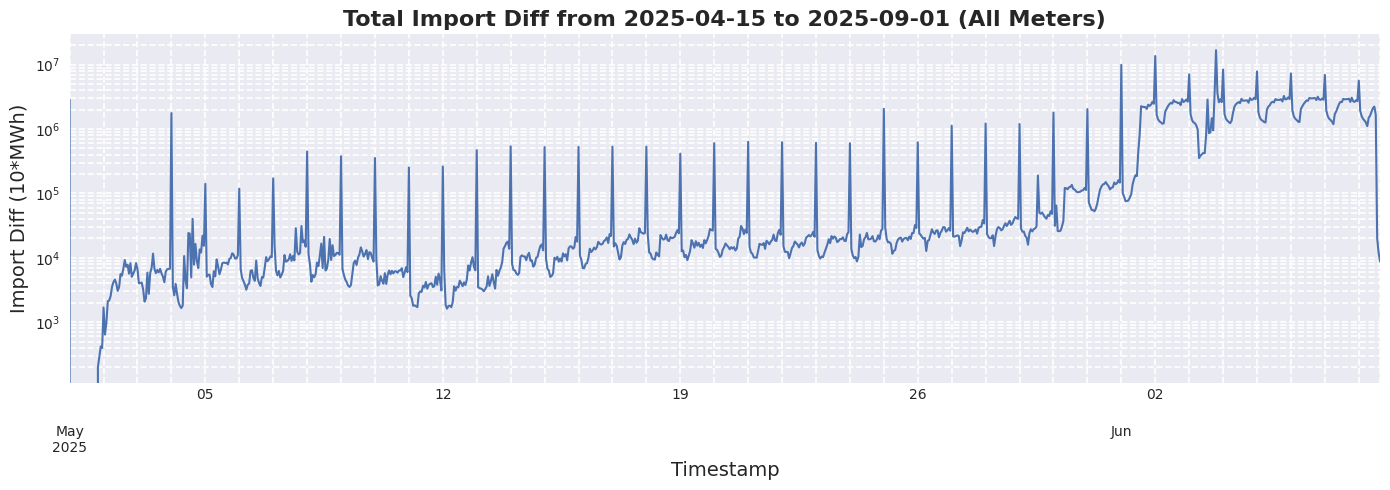

In [15]:
# plot total import_diff based on all meters from time_1 to time_2
time_1 = '2025-04-15'
time_2 = '2025-09-01'
plt.figure(figsize=(14,5))
df_2025 = raw_df[raw_df['timestamp'] >= time_1]
df_2025 = df_2025[raw_df['timestamp'] < time_2]
df_2025 = df_2025.set_index('timestamp')
df_2025 = df_2025.resample('H').sum()
df_2025['import_diff'].plot(lw=1.5)
plt.title(f'Total Import Diff from {time_1} to {time_2} (All Meters)', fontsize=16, weight='bold')
plt.xlabel('Timestamp', fontsize=14)
plt.yscale('log')
plt.ylabel('Import Diff (10*MWh)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.tight_layout()
plt.show()


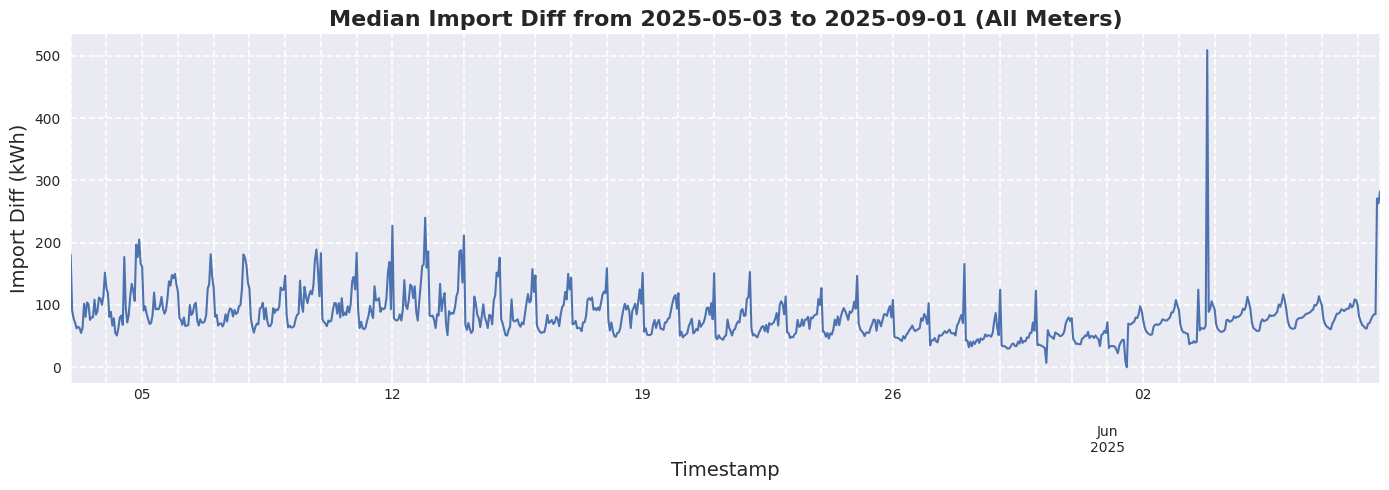

In [33]:
# plot import_diff median based on all meters from time_1 to time_2
time_1 = '2025-05-03'
time_2 = '2025-09-01'
plt.figure(figsize=(14,5))
df_2025 = raw_df[raw_df['timestamp'] >= time_1]
df_2025 = df_2025[df_2025['timestamp'] < time_2]
df_2025 = df_2025.set_index('timestamp')
df_2025 = df_2025.groupby('meter').resample('H').median()
df_2025 = df_2025.reset_index(level='timestamp')
df_2025 = df_2025.set_index('timestamp')
df_2025 = df_2025.groupby('timestamp')['import_diff'].median()
df_2025.plot(lw=1.5)
plt.title(f'Median Import Diff from {time_1} to {time_2} (All Meters)', fontsize=16, weight='bold')
plt.xlabel('Timestamp', fontsize=14)
# plt.yscale('log')
plt.ylabel('Import Diff (kWh)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.tight_layout()
plt.show()

In [17]:
# add hour median import_diff and export_diff to raw_df
# so any row in raw_df will have median import_diff and export_diff for that hour
hourly_median = raw_df.groupby(raw_df['timestamp'].dt.hour).median()[['import_diff', 'export_diff']].rename(columns={
    'import_diff': 'hourly_median_import_diff',
    'export_diff': 'hourly_median_export_diff'
})
raw_df['hour'] = raw_df['timestamp'].dt.hour
raw_df = raw_df.join(hourly_median, on='hour', rsuffix='_median')
raw_df.head()

,meter,timestamp,energy_import,energy_export,transform_coef,import_diff,export_diff,period_min,hour,hourly_median_import_diff,hourly_median_export_diff
0,13836498,2025-06-01 12:15:00,6517117.0,469.0,1.0,0.0,0.0,0.0,12,53.0,0.0
1,13836498,2025-06-01 12:30:00,6517160.0,469.0,1.0,43.0,0.0,15.0,12,53.0,0.0
2,13836498,2025-06-01 12:45:00,6517205.0,469.0,1.0,45.0,0.0,15.0,12,53.0,0.0
3,13836498,2025-06-01 13:00:00,6517249.0,469.0,1.0,44.0,0.0,15.0,13,45.0,0.0
4,13836498,2025-06-01 13:15:00,6517296.0,469.0,1.0,47.0,0.0,15.0,13,45.0,0.0


In [34]:
df_2025.head()

timestamp
2025-05-03 00:00:00    181.0
2025-05-03 01:00:00     91.5
2025-05-03 02:00:00     78.0
2025-05-03 03:00:00     71.5
2025-05-03 04:00:00     62.5
Name: import_diff, dtype: float64

In [20]:
raw_df[raw_df['timestamp'] >= time_1][raw_df['timestamp'] < time_2].shape
# df_2025 = df_2025[df_2025['timestamp'] < time_2]

(2253626, 11)

In [21]:
from statsmodels.tsa.arima.model import ARIMA
total_hourly = raw_df['import_diff'].groupby(raw_df['timestamp'].dt.hour).sum()
model = ARIMA(total_hourly, order=(1, 0, 0))  # Simple AR(1) model
model_fit = model.fit()
forecast = model_fit.forecast(steps=6)  # Predict next 6 hours

           Model       MAE      RMSE      MAPE
0          Naive  4.739583  5.493367  0.091008
1  MovingAverage  5.338268  6.800486  0.093042
2   ExpSmoothing  5.803069  6.737022  0.112781


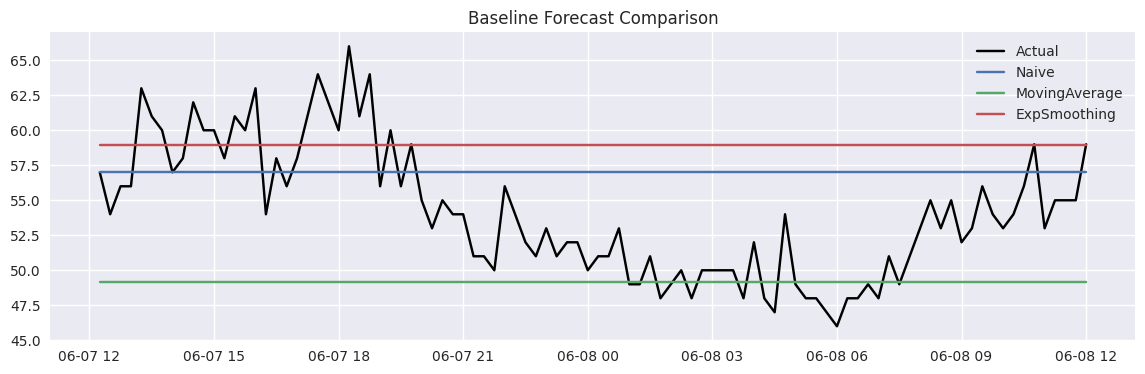

In [22]:
# 5. Baseline Forecasting on Selected Meter
H = 96  # one day horizon (15-min intervals assumed)
series_work = series_clean.dropna()
if len(series_work) <= H + 10:
    raise ValueError('Not enough data for chosen horizon.')

train = series_work.iloc[:-H]
test = series_work.iloc[-H:]

results = []
plots = []

# Naive
f_naive = NaiveForecaster().fit(train.values)
p_naive = f_naive.predict(H)
results.append(('Naive', mae(test.values, p_naive), rmse(test.values, p_naive), mape(test.values, p_naive)))
plots.append(('Naive', p_naive))

# Seasonal naive (if enough history)
# if len(train) >= 96:
#     f_seas = SeasonalNaiveForecaster(season_length=96).fit(train.values)
#     p_seas = f_seas.predict(H)
#     results.append(('SeasonalNaive', mae(test.values, p_seas), rmse(test.values, p_seas), mape(test.values, p_seas)))
#     plots.append(('SeasonalNaive', p_seas))

# Moving average
f_ma = MovingAverageForecaster(window=min(96, max(4, len(train)//10))).fit(train.values)
p_ma = f_ma.predict(H)
results.append(('MovingAverage', mae(test.values, p_ma), rmse(test.values, p_ma), mape(test.values, p_ma)))
plots.append(('MovingAverage', p_ma))

# Exponential smoothing
f_exp = ExpSmoothingForecaster(alpha=0.3).fit(train.values)
p_exp = f_exp.predict(H)
results.append(('ExpSmoothing', mae(test.values, p_exp), rmse(test.values, p_exp), mape(test.values, p_exp)))
plots.append(('ExpSmoothing', p_exp))

metrics_df = pd.DataFrame(results, columns=['Model','MAE','RMSE','MAPE']).sort_values('MAE')
print(metrics_df)

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(test.index, test.values, label='Actual', color='black')
for name, pred in plots:
    ax.plot(test.index, pred, label=name)
ax.set_title('Baseline Forecast Comparison')
ax.legend()
plt.show()


## 6. Future Enhancements

- Implement counter reset detection (large negative raw diffs pre-cleaning).
- Multi-meter panel forecasting (stack & add meter embeddings / clustering).
- Rolling walk-forward backtesting utility.
- Probabilistic forecasting via residual bootstrap.
- Export cleaned panel to Parquet for faster reloads.
- Integrate anomaly detection (e.g., IsolationForest) before model training.
